In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

# Updated imports for new modular pipeline
from xasdenoise.xas_data import data_io, visualization
from xasdenoise.denoising_methods.denoisers import GPDenoiser
from xasdenoise.denoising_pipeline import PipelineConfig, DenoisingPipeline

# Set global font size for all plots
plt.rcParams['figure.dpi'] = 120
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams.update({'font.size': 18})  # Update the default font size for all text
plt.rcParams.update({'axes.titlesize': 18})  # Update the default font size for axes titles
plt.rcParams.update({'axes.labelsize': 18})  # Update the default font size for axes labels
plt.rcParams.update({'xtick.labelsize': 18})  # Update the default font size for x tick labels
plt.rcParams.update({'ytick.labelsize': 18})  # Update the default font size for y tick labelsGPDenoiser

# Load an example dataset
Either load the basic arrays from the csv file. Also we can load the previously created Spectrum object which contains various pre-computed arrays and values. 

Loaded None spectrum.
Loaded 1 spectra from ./data/processed_spectrum.h5


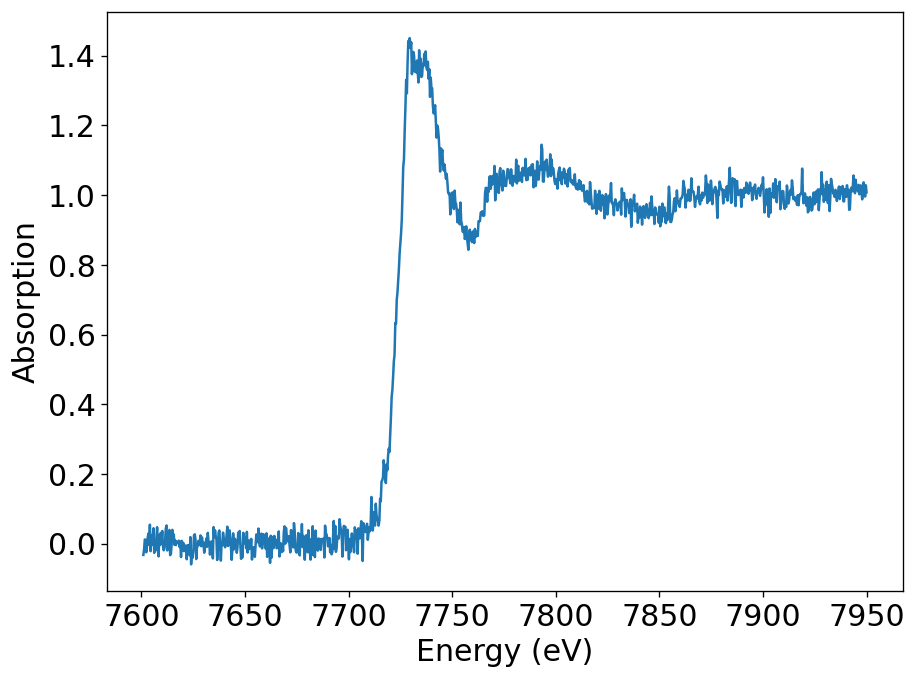

In [2]:
# Load the Spectrum object from an h5 file
spectrum0 = data_io.load_spectra_from_h5('./data/processed_spectrum.h5')

# Bin or downsample the spectrum to reduce the number of points (GPs are very slow with large datasets)
# spectrum0.bin_spectrum(size=1000)
spectrum0.downsample_spectrum(size=1000)
visualization.plot_spectrum(spectrum0)


# Basic denoising pipeline
The denoising pipeline consists of multiple steps such as edge-step estimation, noise estimation, data warping etc. Here we will write a function for the most basic implementation of the denoising pipeline using basic default parameters.

There are three main classes required by the denoising pipeline:
- PipelineConfig() - class which defines a large list of denoising pipeline parameters.
- Denoiser() - class which defines which denoiser to use. At the moment there are three classed RegularDenoiser, EncoderDenoiser, GPDenoiser.
- DenoisingPipeline() - class which takes in the Config and the Denoiser classes and performs various data pre-processing and denoising steps.

In this case we will initialize a simple denoising pipeline using Gaussian Process denoiser. This method has a wide variety of parameters, some of which are set here. Gaussian process denoisers work best for zero-mean signals, which is why we need to remove a step function from the XAS spectrum. In addition, GPs require estimation of the signal lengthscale parameter, which is related to the signal feature width. if the signal normalization flag "normalize_training_data = True" is used, then the signal input domain (energy values) will be normalized to a range of [0, 1]. In doing so the lengthscale value will also be within this range and optimization will be easier.

GP denoising. Using 1000 data points for training out of 1000


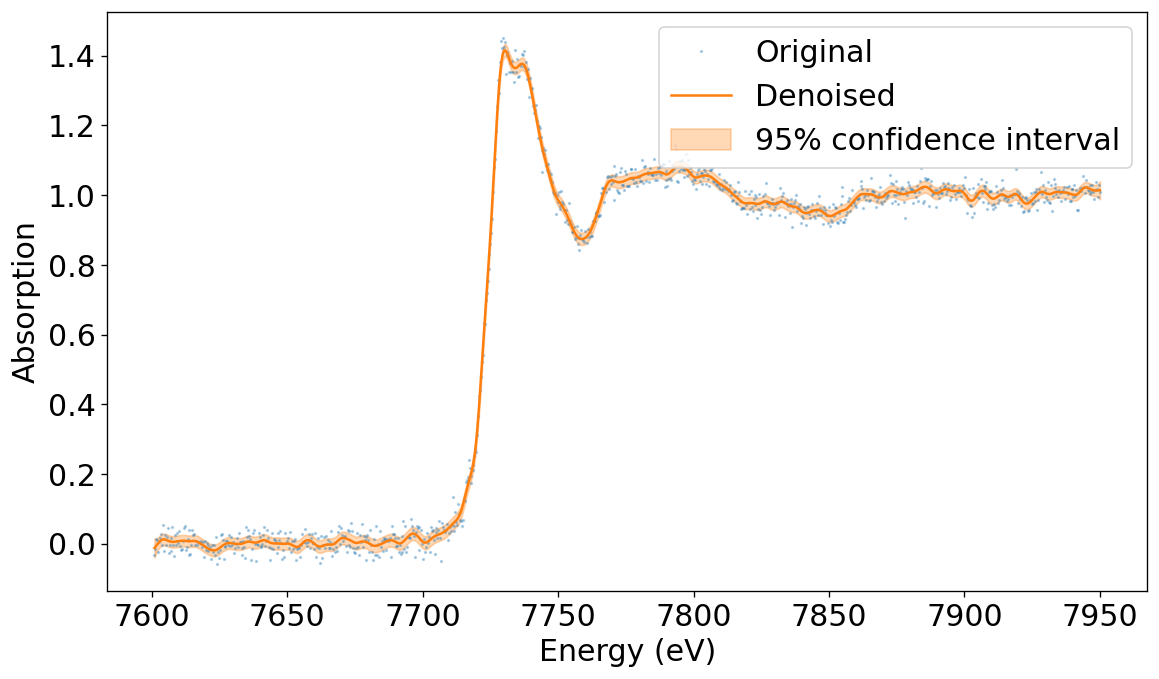

Denoising completed!


In [3]:
def simple_denoising(spectrum_obj):
    """
    Simple denoising using the denoising pipeline.
    
    Returns:
        tuple: (denoised_spectrum, error_estimates, noise_estimates)
    """
    # Create pipeline configuration
    config = PipelineConfig(
        verbose=0,
        data_baseline_removal='step',  # Optional: remove baseline
        warping_interpolation_method=None  # Do not interpolate the data during onto a uniform grid during warping (if warping is used)
    )
    
    # Create denoiser
    denoiser = GPDenoiser(lr=0.1, lengthscale=0.1, verbose=0)
    denoiser.estimate_lengthscale = True  # Estimate the lengthscale automatically, it varies with the energy sampling and needs to be tuned for each dataset
    denoiser.auto_stop_training = True # Terminate training when the loss stops decreasing
    denoiser.normalize_training_data = True # Normalize the training data to a range of [0, 1] for better optimization
    denoiser.mattern_nu = 2.5 # Matern kernel parameter. 2.5 is for very smooth signals, 1.5 is for rough signals, 0.5 is for very rough signals.

    # Create and run pipeline with method chaining
    pipeline = DenoisingPipeline(config)
    pipeline.load_data(spectrum_obj).process(denoiser)
    
    # Get results
    y_denoised, y_error, y_noise = pipeline.get_results()
    
    # Plot results
    pipeline.plot_results(fig_size=(10, 6))
    return y_denoised, y_error, y_noise

# Run denoising
spectrum_obj = spectrum0.copy()  # Copy to avoid modifying original
y_denoised, y_error, y_noise = simple_denoising(spectrum_obj)

print(f"Denoising completed!")

# Perform data warping
There are multiple ways to perform data warping, which has been shown to improve data denoising performance when dealing with non-stationary data (most XAS spectra). With warping the spectrum is transformed into a domain where the data appears more stationary and results in improved denoising performance.

To enable data warping we need to set the "input_warping_method" from None, to one of the warping methods:
- config.input_warping_method = 'kspace' # 'kspace', 'smoothness' or 'kspace_exafs_smoothness_xanes'

For Gaussian Process denoisers we do not need interpolation onto a uniform grid, which requires setting
- config.warping_interpolation_method = None

GP denoising. Using 1000 data points for training out of 1000


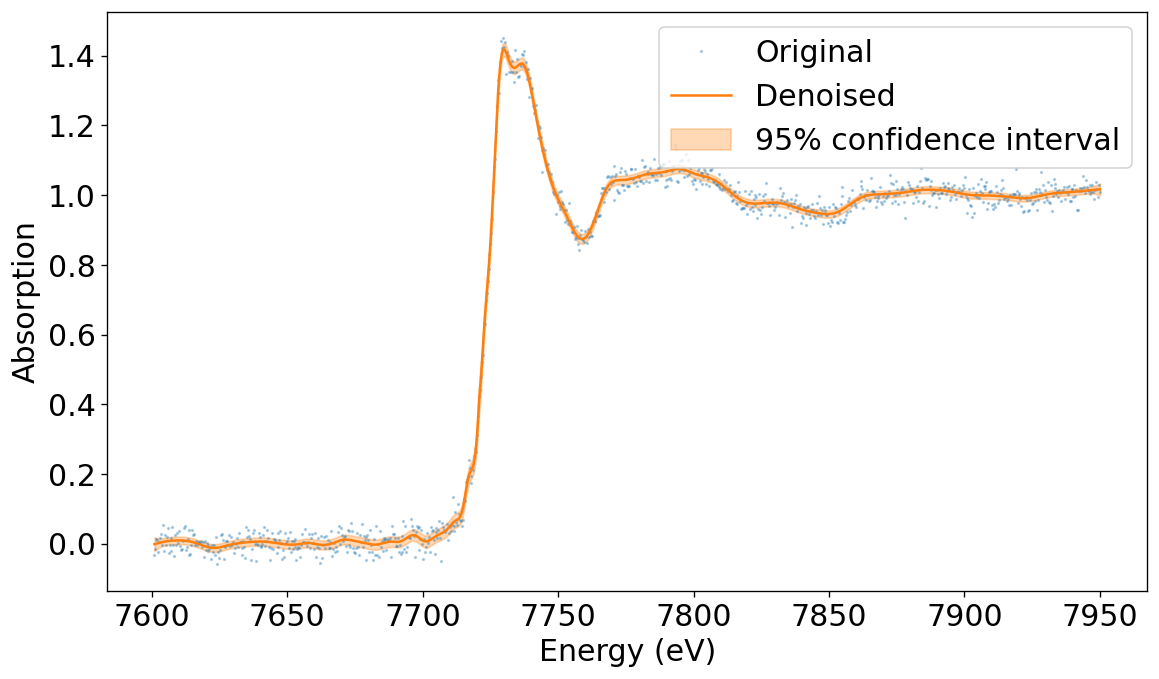

Denoising completed!


In [4]:
def denoising_with_warping(spectrum_obj):
    """
    Denoising with stationarity warping.
    
    Returns:
        tuple: (denoised_spectrum, error_estimates, noise_estimates)
    """
    # Create pipeline configuration
    config = PipelineConfig(
        verbose=0,
        data_baseline_removal='step',  # Optional: remove baseline
        warping_interpolation_method=None,  # Do not interpolate the data during onto a uniform grid during warping (if warping is used)
        input_warping_method = 'kspace'
    )
    
    # Create denoiser
    denoiser = GPDenoiser(lr=0.1, lengthscale=0.1, verbose=0)
    denoiser.estimate_lengthscale = True  # Estimate the lengthscale automatically, it varies with the energy sampling and needs to be tuned for each dataset
    denoiser.auto_stop_training = True # Terminate training when the loss stops decreasing
    denoiser.normalize_training_data = True # Normalize the training data to a range of [0, 1] for better optimization
    denoiser.mattern_nu = 2.5 # Matern kernel parameter. 2.5 is for very smooth signals, 1.5 is for rough signals, 0.5 is for very rough signals.

    # Create and run pipeline with method chaining
    pipeline = DenoisingPipeline(config)
    pipeline.load_data(spectrum_obj).process(denoiser)
    
    # Get results
    y_denoised, y_error, y_noise = pipeline.get_results()
    
    # Plot results
    pipeline.plot_results(fig_size=(10, 6))
    return y_denoised, y_error, y_noise

# Run denoising
spectrum_obj = spectrum0.copy()  # Copy to avoid modifying original
y_denoised, y_error, y_noise = denoising_with_warping(spectrum_obj)

print(f"Denoising completed!")

# Noise prior estimation
Gaussian Process denoiser performance depends on how well we can estimate the signal noise. This done within the pipeline by trying to estimate the noise level across the signal. An even better approach is to fit small local Gaussian Process models across multiple signal regions. This way we can find approxiamte noise level within each region and use it for the final data denoising step.

GP denoising with windows. Using window size of 100. Window 1/10
GP denoising with windows. Using window size of 100. Window 2/10
GP denoising with windows. Using window size of 100. Window 3/10
GP denoising with windows. Using window size of 100. Window 4/10
GP denoising with windows. Using window size of 100. Window 5/10
GP denoising with windows. Using window size of 100. Window 6/10
GP denoising with windows. Using window size of 100. Window 7/10
GP denoising with windows. Using window size of 100. Window 8/10
GP denoising with windows. Using window size of 100. Window 9/10
GP denoising with windows. Using window size of 100. Window 10/10
GP denoising. Using 1000 data points for training out of 1000


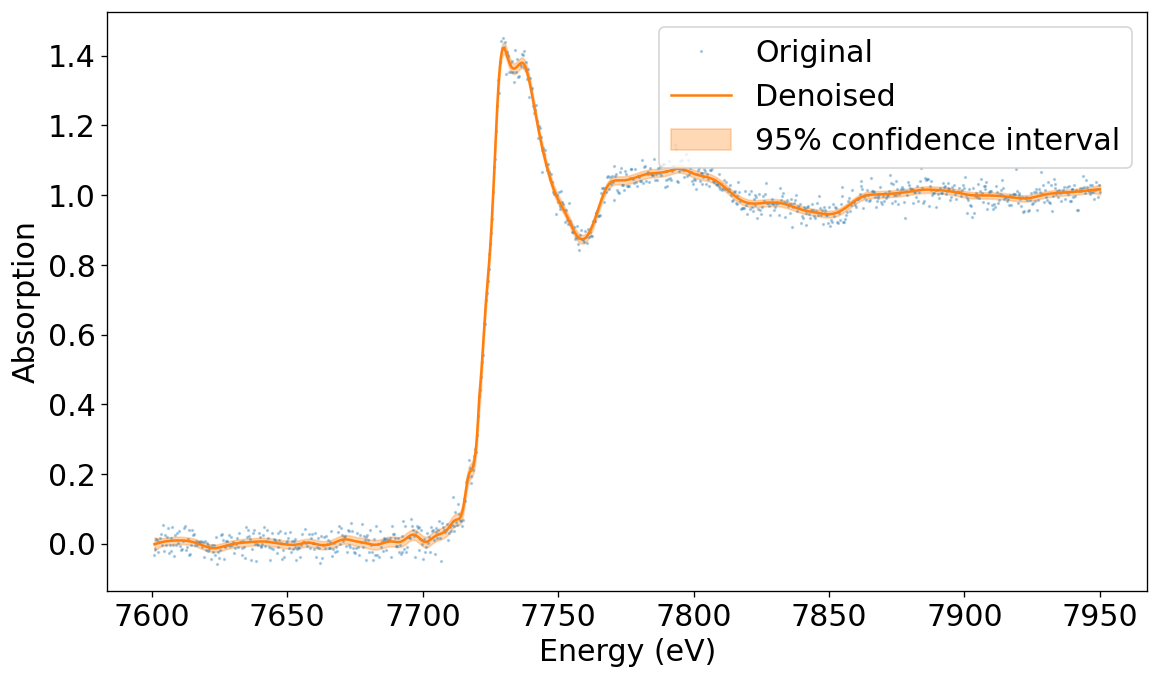

Denoising completed!


In [5]:
def denoising_with_warping_and_noise_estimation(spectrum_obj):
    """
    Denoising with stationarity warping.
    
    Returns:
        tuple: (denoised_spectrum, error_estimates, noise_estimates)
    """
    # Create pipeline configuration
    config = PipelineConfig(
        verbose=0,
        data_baseline_removal='step',  # Optional: remove baseline
        warping_interpolation_method=None,  # Do not interpolate the data during onto a uniform grid during warping (if warping is used)
        input_warping_method = 'kspace'
    )
    
    # Create denoiser
    denoiser = GPDenoiser(lr=0.1, lengthscale=0.1, verbose=0)
    denoiser.estimate_lengthscale = True  # Estimate the lengthscale automatically, it varies with the energy sampling and needs to be tuned for each dataset
    denoiser.auto_stop_training = True # Terminate training when the loss stops decreasing
    denoiser.normalize_training_data = True # Normalize the training data to a range of [0, 1] for better optimization
    denoiser.mattern_nu = 2.5 # Matern kernel parameter. 2.5 is for very smooth signals, 1.5 is for rough signals, 0.5 is for very rough signals.
    denoiser.noise_window_gp = np.ceil(spectrum_obj.energy.size // 10)  # Set the noise window size to 10% of the data size
    denoiser.learn_additional_noise = True  # Enable learning additional noise
    denoiser.refine_noise_estimate = True  # Enable noise refinement
    denoiser.filter_refined_noise_estimate = True  # Filter the refined noise estimate


    # Create and run pipeline with method chaining
    pipeline = DenoisingPipeline(config)
    pipeline.load_data(spectrum_obj).process(denoiser)
    
    # Get results
    y_denoised, y_error, y_noise = pipeline.get_results()
    
    # Plot results
    pipeline.plot_results(fig_size=(10, 6))
    return y_denoised, y_error, y_noise

# Run denoising
spectrum_obj = spectrum0.copy()  # Copy to avoid modifying original
y_denoised, y_error, y_noise = denoising_with_warping_and_noise_estimation(spectrum_obj)

print(f"Denoising completed!")

# Denoise fully sized data using GPs with smart downsampling
We can iteratively estimate where data points are sampled densely and can be downsampled to ensure that the GP regression is done on a smaller dataset without loss of spectral information.

GPU accelerated denoising is also highly beneficial for alrge datasets which can be enabled via "denoiser.use_gpu = True".

Loaded None spectrum.
Loaded 1 spectra from ./data/processed_spectrum.h5


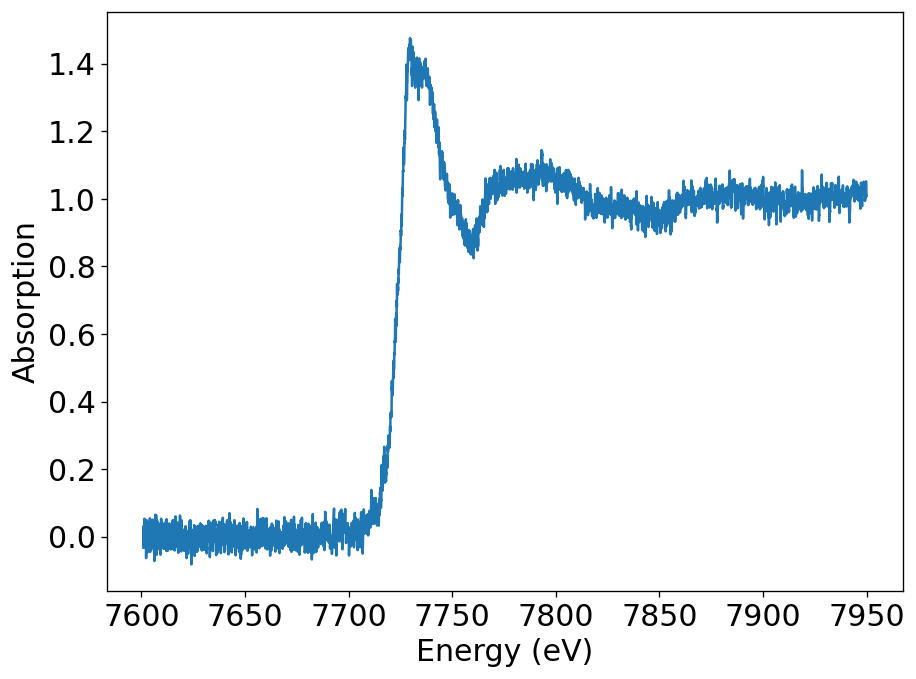

In [6]:
# Load the Spectrum object from an h5 file
spectrum0 = data_io.load_spectra_from_h5('./data/processed_spectrum.h5')
visualization.plot_spectrum(spectrum0)

Using Apple GPU via MPS (built) backend
GP denoising with downsampling. Using 1000 data points out of 9999
GP denoising. Using 1000 data points for training out of 9999
GP denoising with downsampling. Using 1000 data points out of 9999
GP denoising. Using 1000 data points for training out of 9999
GP denoising with downsampling. Using 1000 data points out of 9999
GP denoising. Using 1000 data points for training out of 9999
GP denoising with downsampling. Using 1000 data points out of 9999
GP denoising. Using 1000 data points for training out of 9999
GP denoising with downsampling. Using 1000 data points out of 9999
GP denoising. Using 1000 data points for training out of 9999
GP denoising with downsampling. Using 1000 data points out of 9999
GP denoising with windows. Using window size of 99. Window 1/11
GP denoising with windows. Using window size of 99. Window 2/11
GP denoising with windows. Using window size of 99. Window 3/11
GP denoising with windows. Using window size of 99. Wind

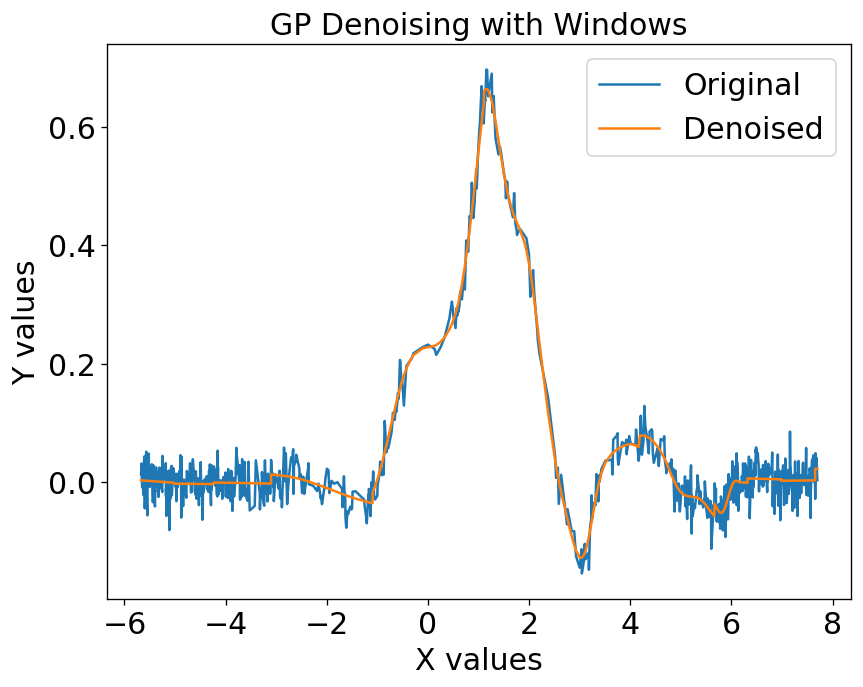

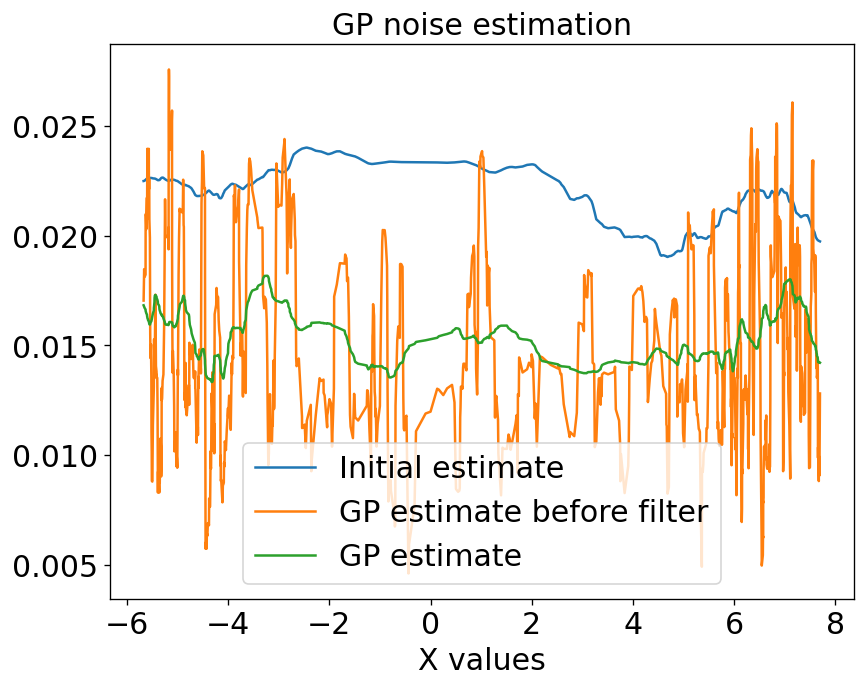

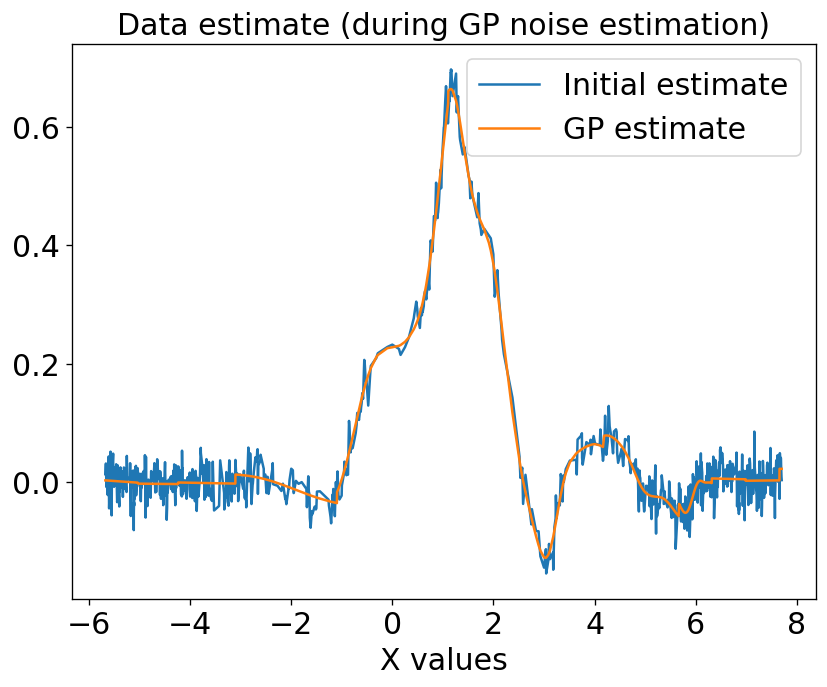

GP denoising. Using 1000 data points for training out of 9999


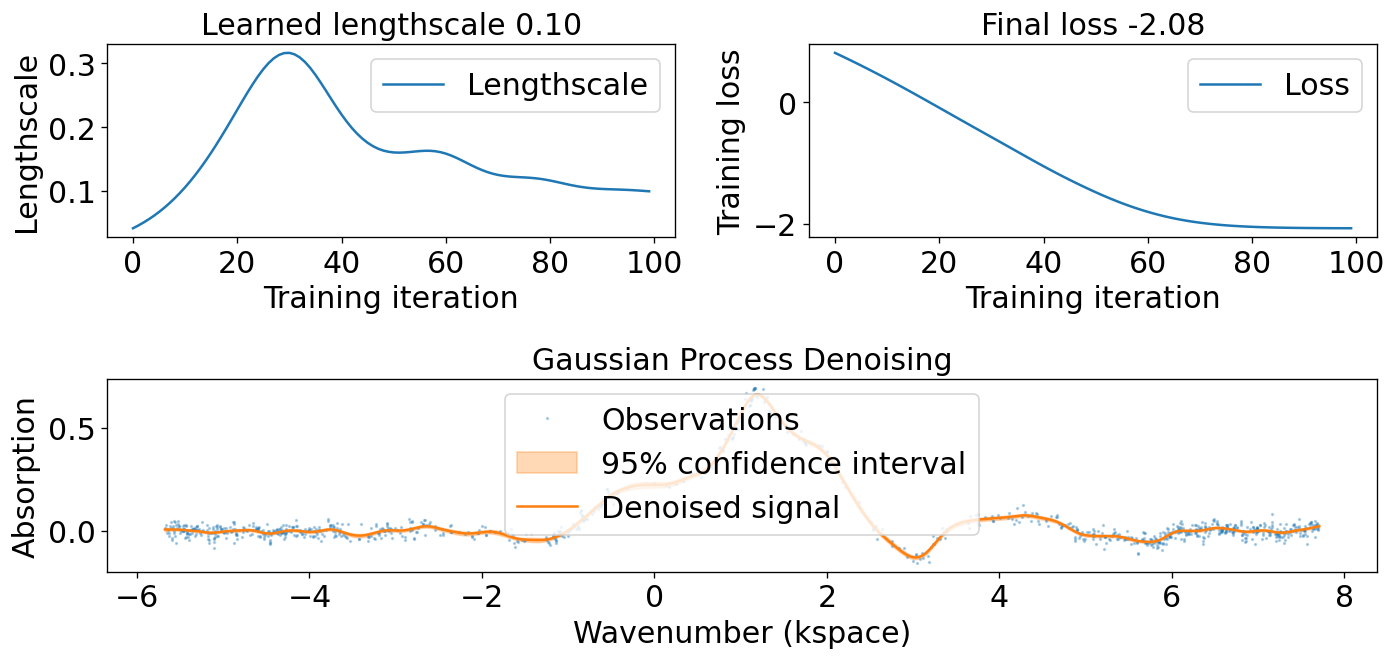

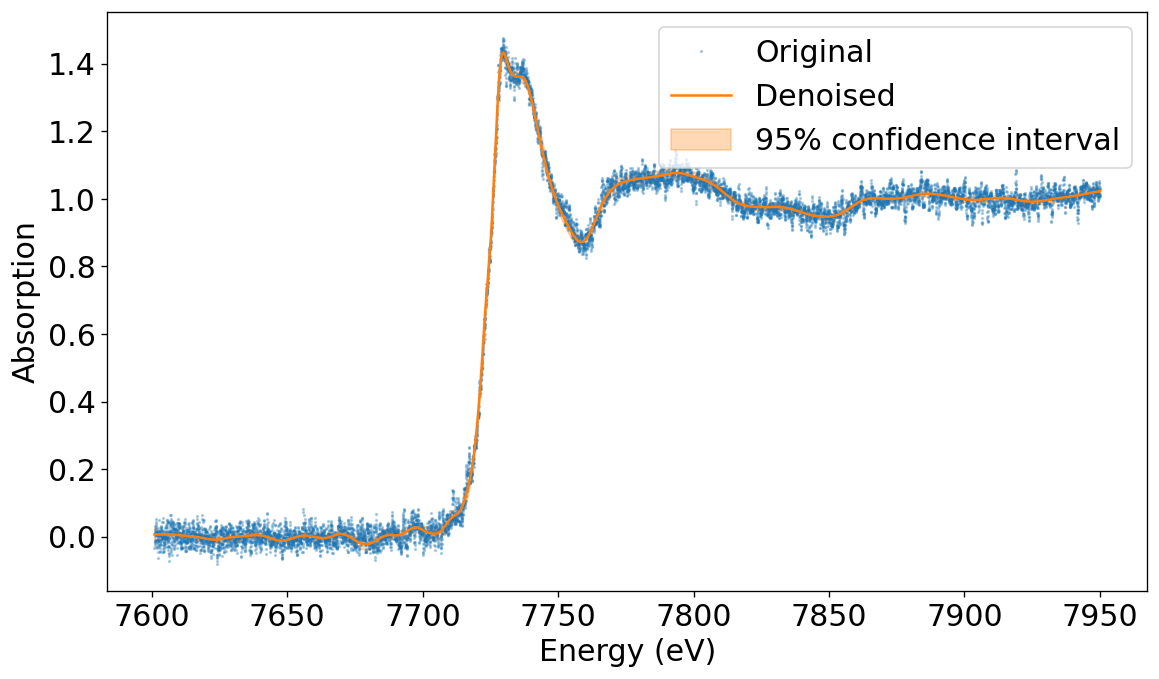

Denoising completed!


In [7]:
def denoising_with_warping_and_noise_estimation(spectrum_obj):
    """
    Denoising with stationarity warping.
    
    Returns:
        tuple: (denoised_spectrum, error_estimates, noise_estimates)
    """
    # Create pipeline configuration
    config = PipelineConfig(
        verbose=0,
        data_baseline_removal='step_not_normalized',  # Optional: remove baseline
        warping_interpolation_method=None,  # Do not interpolate the data during onto a uniform grid during warping (if warping is used)
        input_warping_method = 'kspace',
        data_downsampling_method='smoothness',
        downsampling_pts=1000
    )
    
    # Create denoiser
    denoiser = GPDenoiser(lr=0.1, lengthscale=0.1, verbose=1)
    denoiser.estimate_lengthscale = True  # Estimate the lengthscale automatically, it varies with the energy sampling and needs to be tuned for each dataset
    denoiser.auto_stop_training = True # Terminate training when the loss stops decreasing
    denoiser.normalize_training_data = True # Normalize the training data to a range of [0, 1] for better optimization
    denoiser.mattern_nu = 2.5 # Matern kernel parameter. 2.5 is for very smooth signals, 1.5 is for rough signals, 0.5 is for very rough signals.
    denoiser.noise_window_gp = np.ceil(spectrum_obj.energy.size // 10)  # Set the noise window size to 10% of the data size
    denoiser.learn_additional_noise = True  # Enable learning additional noise
    denoiser.refine_noise_estimate = True  # Enable noise refinement
    denoiser.filter_refined_noise_estimate = True  # Filter the refined noise estimate
    denoiser.use_gpu = True
    
    # Create and run pipeline with method chaining
    pipeline = DenoisingPipeline(config)
    pipeline.load_data(spectrum_obj).process(denoiser)
    
    # Get results
    y_denoised, y_error, y_noise = pipeline.get_results()
    
    # Plot results
    pipeline.plot_results(fig_size=(10, 6))
    return y_denoised, y_error, y_noise

# Run denoising
spectrum_obj = spectrum0.copy()  # Copy to avoid modifying original
y_denoised, y_error, y_noise = denoising_with_warping_and_noise_estimation(spectrum_obj)

print(f"Denoising completed!")